# Energy Use

Analysing household energy use

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt# Import a scoring metric to compare methods

from datetime import timedelta, datetime

## Read Data

Consumption data downloaded from octopus. Different files for _historical_ and _latest_.

 - Historical are 9th October 2021 (the earliest data we have) until end of 8th October 2022 to make a good benchmark. 
 - Latest is from 9th August 2022 to present
 
Also add a cost column. Current prices are:
 - £0.075 from 00:30 - 04:30
 - £0.3882 all other times
 
TODO
 - [ ] Automate collection from this page https://octopus.energy/dashboard/new/accounts/A-ADD72A6B/consumption/home
 

In [2]:
# Precise times of historical data
start_historical = datetime.fromisoformat("2021-10-09 00:00:00")
end_historical   = datetime.fromisoformat("2022-10-08 23:30:00")

# A lookup with energy prices in half-hourly time slots
price_lookup = [0.3882] + [0.075] * 8 + [0.3882] * 39

def calc_tarrif(row, price_lookup = price_lookup, cost=False):
    """Given a row of data, use the date (row index), energy use and price lookup
    to calculate the actual cost of energy (if cost=True) or the tarrif (if cost=False)."""
    assert len(price_lookup) == 48, f"Price lookup should have 48 items, not: {len(price_lookup)}"
    date = row.name # Stupidly the index is referenced using 'name' in pandas
    energy = row.energy
    # Find the tarrif for this half hourly slot. Multiply decimal hour by 2
    price_index = int( (date.hour + (date.minute / 60) ) * 2 )
    #print(date, price_index, ( date.hour + (date.minute / 60) ) * 2, price_lookup[price_index])
    tarrif = price_lookup[price_index]
    if cost:
        return tarrif * energy
    else:
        return tarrif

def read_data(filename):
    """Process to read and clean data is the same for historical and latest datasets"""
    raw_data = pd.read_csv(os.path.join("data", filename))
    
    # Drop whitespace
    raw_data[' Start'] = raw_data[' Start'].apply(lambda x: x.strip())
    raw_data[' End'] = raw_data[' End'].apply(lambda x: x.strip())

    raw_data['energy'] = raw_data['Consumption (kWh)'] # Better column label

    # Create date objects
    # Do it properly, but the time offset is really annoying!
    #raw_data['StartDate'] = pd.to_datetime(raw_data[' Start'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
    #raw_data['EndDate'] =  pd.to_datetime(raw_data[' End'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
    # Ignore the time offset by splitting on the '+'
    raw_data['StartDate'] = raw_data[' Start'].apply(lambda x: pd.to_datetime(x.split('+')[0], format='%Y-%m-%dT%H:%M:%S') )
    raw_data['EndDate']     = raw_data[' End'].apply(lambda x: pd.to_datetime(x.split('+')[0], format='%Y-%m-%dT%H:%M:%S') )

    # Index is the start point for 30 minute interval
    #raw_data['Date'] = raw_data['StartDate']
    #raw_data = raw_data.set_index('Date')
    raw_data.index = pd.DatetimeIndex(raw_data.StartDate)
    raw_data.index.name = "Date"

    # Now just take the columns that we want
    raw_data = raw_data.loc[:,['energy']]
    
    # Add tarrif and cost columns 
    raw_data['tarrif'] = raw_data.apply(calc_tarrif, axis=1, cost=False)
    raw_data['cost'] = raw_data.apply(calc_tarrif, axis=1, cost=True)

    # Make some useful ones
    #df['Day'] = df.index.map(lambda x:x.day) # (had to do it this way before I had the DateTimeIndex set up properly)
    raw_data['day'] = raw_data.index.day
    raw_data['month'] = raw_data.index.month
    raw_data['year'] = raw_data.index.year
    raw_data['dayofyear'] = raw_data.index.dayofyear
    # Hour as a decimal
    #raw_data['hour'] = raw_data.index.map(lambda x:x.hour) + raw_data.index.map(lambda x:x.minute) / 60
    raw_data['hour'] =  raw_data.index.hour + (raw_data.index.minute / 60)
    # Season (thanks https://stackoverflow.com/questions/44124436/python-datetime-to-season)
    #[x%12 // 3 + 1 for x in range(13)]
    raw_data['season'] = raw_data.index.month%12 // 3 + 1
    return raw_data

# Read the latext and cut out any entries that occur during the 'history' period
# (plus 30 mins because otherwise the last/first half hour period is repeated)
latest_df = read_data("consumption-latest.csv")
latest_df = latest_df.loc[end_historical+timedelta(minutes=30):]

# I edited the historical file in vim so it should have the full year (no need to edit)
hist_df = read_data("consumption-historical.csv.zip")


In [3]:
hist_df

,energy,tarrif,cost,day,month,year,dayofyear,hour,season
Date,,,,,,,,,
2021-10-09 00:00:00,0.074,0.3882,0.028727,9,10,2021,282,0.0,4
2021-10-09 00:30:00,0.063,0.0750,0.004725,9,10,2021,282,0.5,4
2021-10-09 01:00:00,0.040,0.0750,0.003000,9,10,2021,282,1.0,4
2021-10-09 01:30:00,0.062,0.0750,0.004650,9,10,2021,282,1.5,4
2021-10-09 02:00:00,0.064,0.0750,0.004800,9,10,2021,282,2.0,4
...,...,...,...,...,...,...,...,...,...
2022-10-08 21:30:00,0.109,0.3882,0.042314,8,10,2022,281,21.5,4
2022-10-08 22:00:00,0.078,0.3882,0.030280,8,10,2022,281,22.0,4
2022-10-08 22:30:00,0.084,0.3882,0.032609,8,10,2022,281,22.5,4


In [4]:
latest_df

,energy,tarrif,cost,day,month,year,dayofyear,hour,season
Date,,,,,,,,,
2022-10-09 00:00:00,0.041,0.3882,0.015916,9,10,2022,282,0.0,4
2022-10-09 00:30:00,0.062,0.0750,0.004650,9,10,2022,282,0.5,4
2022-10-09 01:00:00,0.471,0.0750,0.035325,9,10,2022,282,1.0,4
2022-10-09 01:30:00,0.293,0.0750,0.021975,9,10,2022,282,1.5,4
2022-10-09 02:00:00,0.383,0.0750,0.028725,9,10,2022,282,2.0,4
...,...,...,...,...,...,...,...,...,...
2023-01-22 21:30:00,0.581,0.3882,0.225544,22,1,2023,22,21.5,1
2023-01-22 22:00:00,0.107,0.3882,0.041537,22,1,2023,22,22.0,1
2023-01-22 22:30:00,0.493,0.3882,0.191383,22,1,2023,22,22.5,1


Sanity checks

## Sanity check plots

Plot to check the data look sensible

Daily monthly totals

In [ ]:
for (df, title) in [(hist_df, "Historical"), (latest_df, "Latest")]: 
    df.groupby(df.index.floor('D'))['energy'].sum().plot(
        figsize=(15, 7), title=f"Daily Energy Use", legend=True, label=title)

Monthly totals

In [ ]:
#floor(30D) gives 30 days; approx 1 month

for (df, title) in [(hist_df, "Historical"), (latest_df, "Latest")]: 
    df.groupby(df.index.floor('7D'))['energy'].sum().plot(
        figsize=(15, 7), title=f"Weekly Energy Use", legend=True, label=title)

One week in May, including tarrif

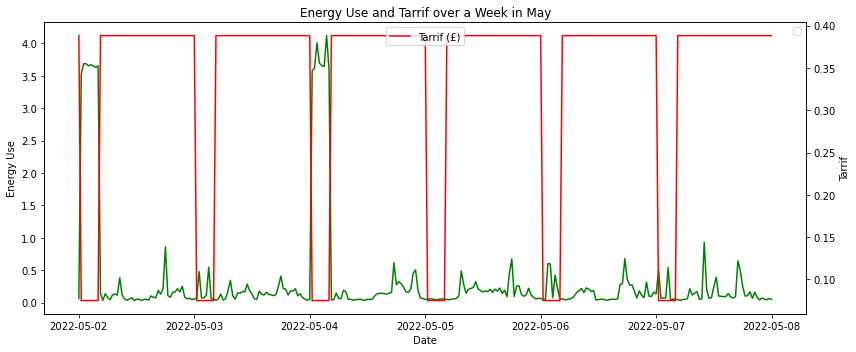

In [5]:
#temp = hist_df.loc[datetime.fromisoformat("2022-05-02 00:00:00+01:00"):datetime.fromisoformat("2022-05-08 23:59:59+01:00"),]
temp = hist_df.loc[datetime.fromisoformat("2022-05-02"):datetime.fromisoformat("2022-05-08"),]

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title('Energy Use and Tarrif over a Week in May')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

#ax.set_xticks(gdp['date'].dt.date)
#ax.set_xticklabels(gdp['date'].dt.year, rotation=90)
#ax.yaxis.grid(color='lightgray', linestyle='dashed')

plt.tight_layout()
plt.show()
#temp.plot(figsize=(15, 7), title="Energy over one week in may (for example)", legend=True, label="energy");
#hist_df.loc[datetime.fromisoformat("2022-05-02 00:00:00+01:00"):datetime.fromisoformat("2022-05-08 23:59:59+01:00"),
#         'energy'].plot(figsize=(15, 7), title="Energy over one week in may (for example)");



Another short week in Dec (mostly to check daylight saving hasn't wrecked things, and to check the latest data)

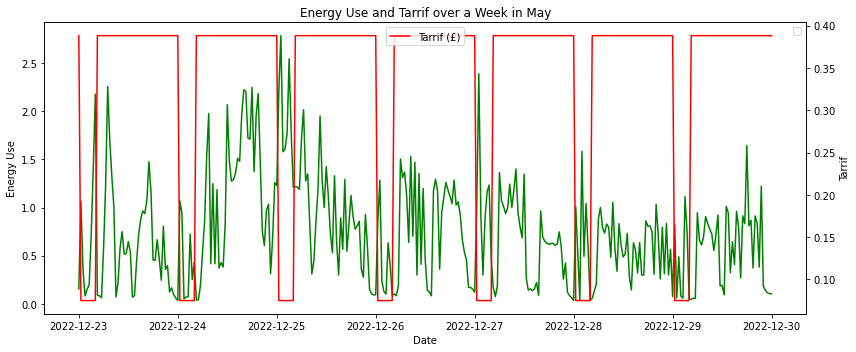

In [6]:
temp = latest_df.loc[datetime.fromisoformat("2022-12-23"):datetime.fromisoformat("2022-12-30"),]

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title('Energy Use and Tarrif over a Week in May')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

A day in Dec (so I can compare against a bill)

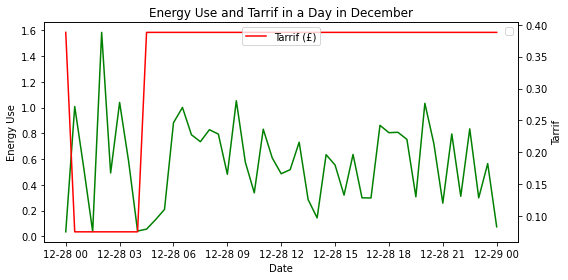

In [8]:
temp = latest_df.loc[datetime.fromisoformat("2022-12-28"):datetime.fromisoformat("2022-12-29"),]

fig, ax = plt.subplots(figsize=(8,4))
ax2 = ax.twinx()

ax.set_title('Energy Use and Tarrif in a Day in December')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

#ax.set_xticks(gdp['date'].dt.date)
#ax.set_xticklabels(gdp['date'].dt.year, rotation=90)
#ax.yaxis.grid(color='lightgray', linestyle='dashed')

plt.tight_layout()
plt.show()
#temp.plot(figsize=(15, 7), title="Energy over one week in may (for example)", legend=True, label="energy");
#hist_df.loc[datetime.fromisoformat("2022-05-02 00:00:00+01:00"):datetime.fromisoformat("2022-05-08 23:59:59+01:00"),
#         'energy'].plot(figsize=(15, 7), title="Energy over one week in may (for example)");



## Recent costs: cheap overnight tarrif better?

Look at the last 2 weeks and estimate whether an overnight tarrif would have been better than a normal one.

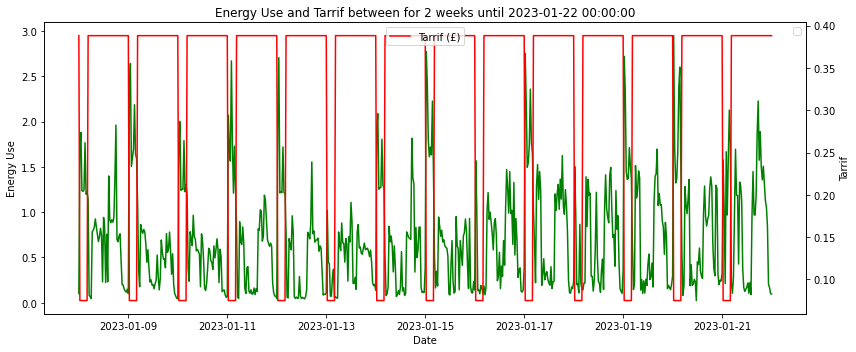

In [71]:
# Cut 2 weeks and plot use and (existing) tarrif

date_now = datetime(2023,1,22,0,0)
df = latest_df.loc[date_now-timedelta(weeks=2):date_now]

# Plot 

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title(f'Energy Use and Tarrif between for 2 weeks until {date_now}')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(df['energy'], color='green')

ax2.plot(df['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

Total cost (actual) and then hypothetical (if on standard tarrif)

In [72]:
# Current (actual) cost

# Calculated the cost previously, so can just sum that column
actual_cost_total = df.cost.sum() 

# Sanity check (this is the formula used to estimate hypothetical cost in the next chunk)
temp = df.apply(calc_tarrif, axis=1, price_lookup=price_lookup, cost=True)
assert actual_cost_total == temp.sum(), f"Should be equal: {actual_cost_total}, {temp.sum()}" 

print(f"Current (actual) cost over that period is £{round(actual_cost)}.")

Current (actual) cost over that period is £138.


In [73]:
# New cost asuming on standard tarrif.

# Hypothetical tarrif is 33p all day
hypothetical_price_lookup = [0.33] * 48 

# Calculate that cost
hypothetical_cost = df.apply(calc_tarrif, axis=1, price_lookup=hypothetical_price_lookup, cost=True)
df = df.assign(hypothetical_cost=hypothetical_cost)

hypothetical_cost_total = df.hypothetical_cost.sum() 
print(f"Hypothetical cost over that period is £{round(hypothetical_cost_total)}.")

Hypothetical cost over that period is £160.


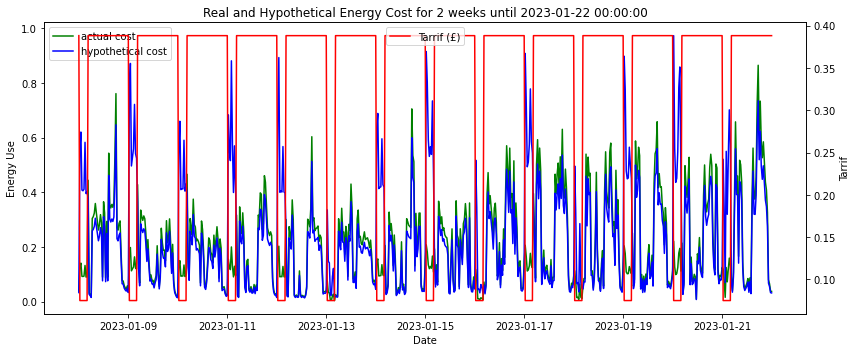

In [74]:
# Plot 

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title(f'Real and Hypothetical Energy Cost for 2 weeks until {date_now}')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.plot(df['cost'], color='green', label="actual cost")
ax.plot(df['hypothetical_cost'], color='blue', label="hypothetical cost")
#ax.legend(["actual cost", "hypothetical cost"], loc='upper right')
ax.legend(loc='upper left')

ax2.plot(df['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

Look at that cumulatively

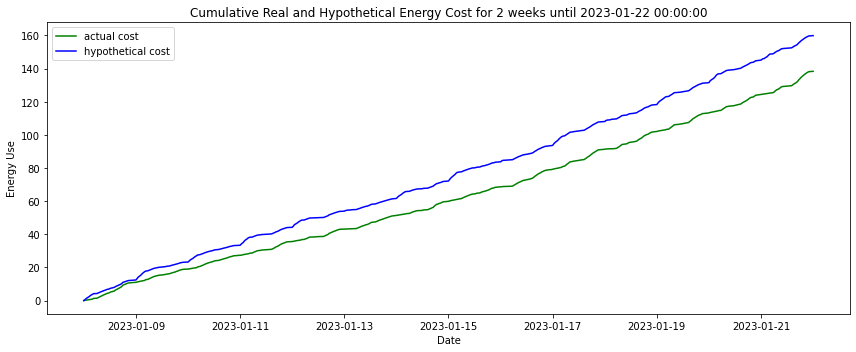

In [75]:
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title(f'Cumulative Real and Hypothetical Energy Cost for 2 weeks until {date_now}')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.plot(df['cost'].cumsum(), color='green', label="actual cost")
ax.plot(df['hypothetical_cost'].cumsum(), color='blue', label="hypothetical cost")
#ax.legend(["actual cost", "hypothetical cost"], loc='upper right')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Create Averages

Want to estimate new costs after installing heat pump. Need to create some benchmarks. Average use for different days (e.g. weekday in winter, weekend in summer, etc...)